<a href="https://colab.research.google.com/github/eemaansheikh/Data_Science_2025/blob/main/%5BFIXED%5D_EemaanSheikh_Unit6Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Project: Making a Generalized Linear Model (multiple predictors)

**Task**:

Two parts:

1. Propose a data set that's compatible with a generilized linear model structure built with pymc and/or bambi. Your data must have more than three potential predictor variables. I must approve your submission before you move on to part 2.

2. Create, analyze, and present a generalized linear model using pymc within the colab environment, on a data set of your choice, with the following conditions:
  - your final model must have more than 2 predictors. The intercept term doesn't count as a predictor here (even though technically it is).
  - You must document and explain your model selection method. This means you must show that your likelihood/link function combo is better than at least one other choice of likelihood/link function.
  - You must document and explain your variable selection method. This means you must show that your final model is better than at least one other version of the model with a different selection of variables.



# **DATA SET, PAIR PLOT, and CAUSAL DIAGRAM**

student test performance: https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression

In [ ]:
!pip install bambi

In [7]:
import bambi as bmb

In [8]:

import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
performance = pd.read_csv('https://raw.githubusercontent.com/eemaansheikh/Data_Science_2025/refs/heads/main/Student_Performance.csv')

In [ ]:
performance

In [ ]:
sns.pairplot(performance)

cool data set, but no definite trend

https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho

In [ ]:
cars = pd.read_csv('https://raw.githubusercontent.com/eemaansheikh/Data_Science_2025/refs/heads/main/CAR%20DETAILS%20FROM%20CAR%20DEKHO.csv')

In [ ]:
cars

In [ ]:
sns.pairplot(cars)

too many categorical variables

In [10]:
cali_house = pd.read_csv('https://raw.githubusercontent.com/eemaansheikh/Data_Science_2025/refs/heads/main/housing%5B1%5D.csv')

In [11]:
cali_house

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


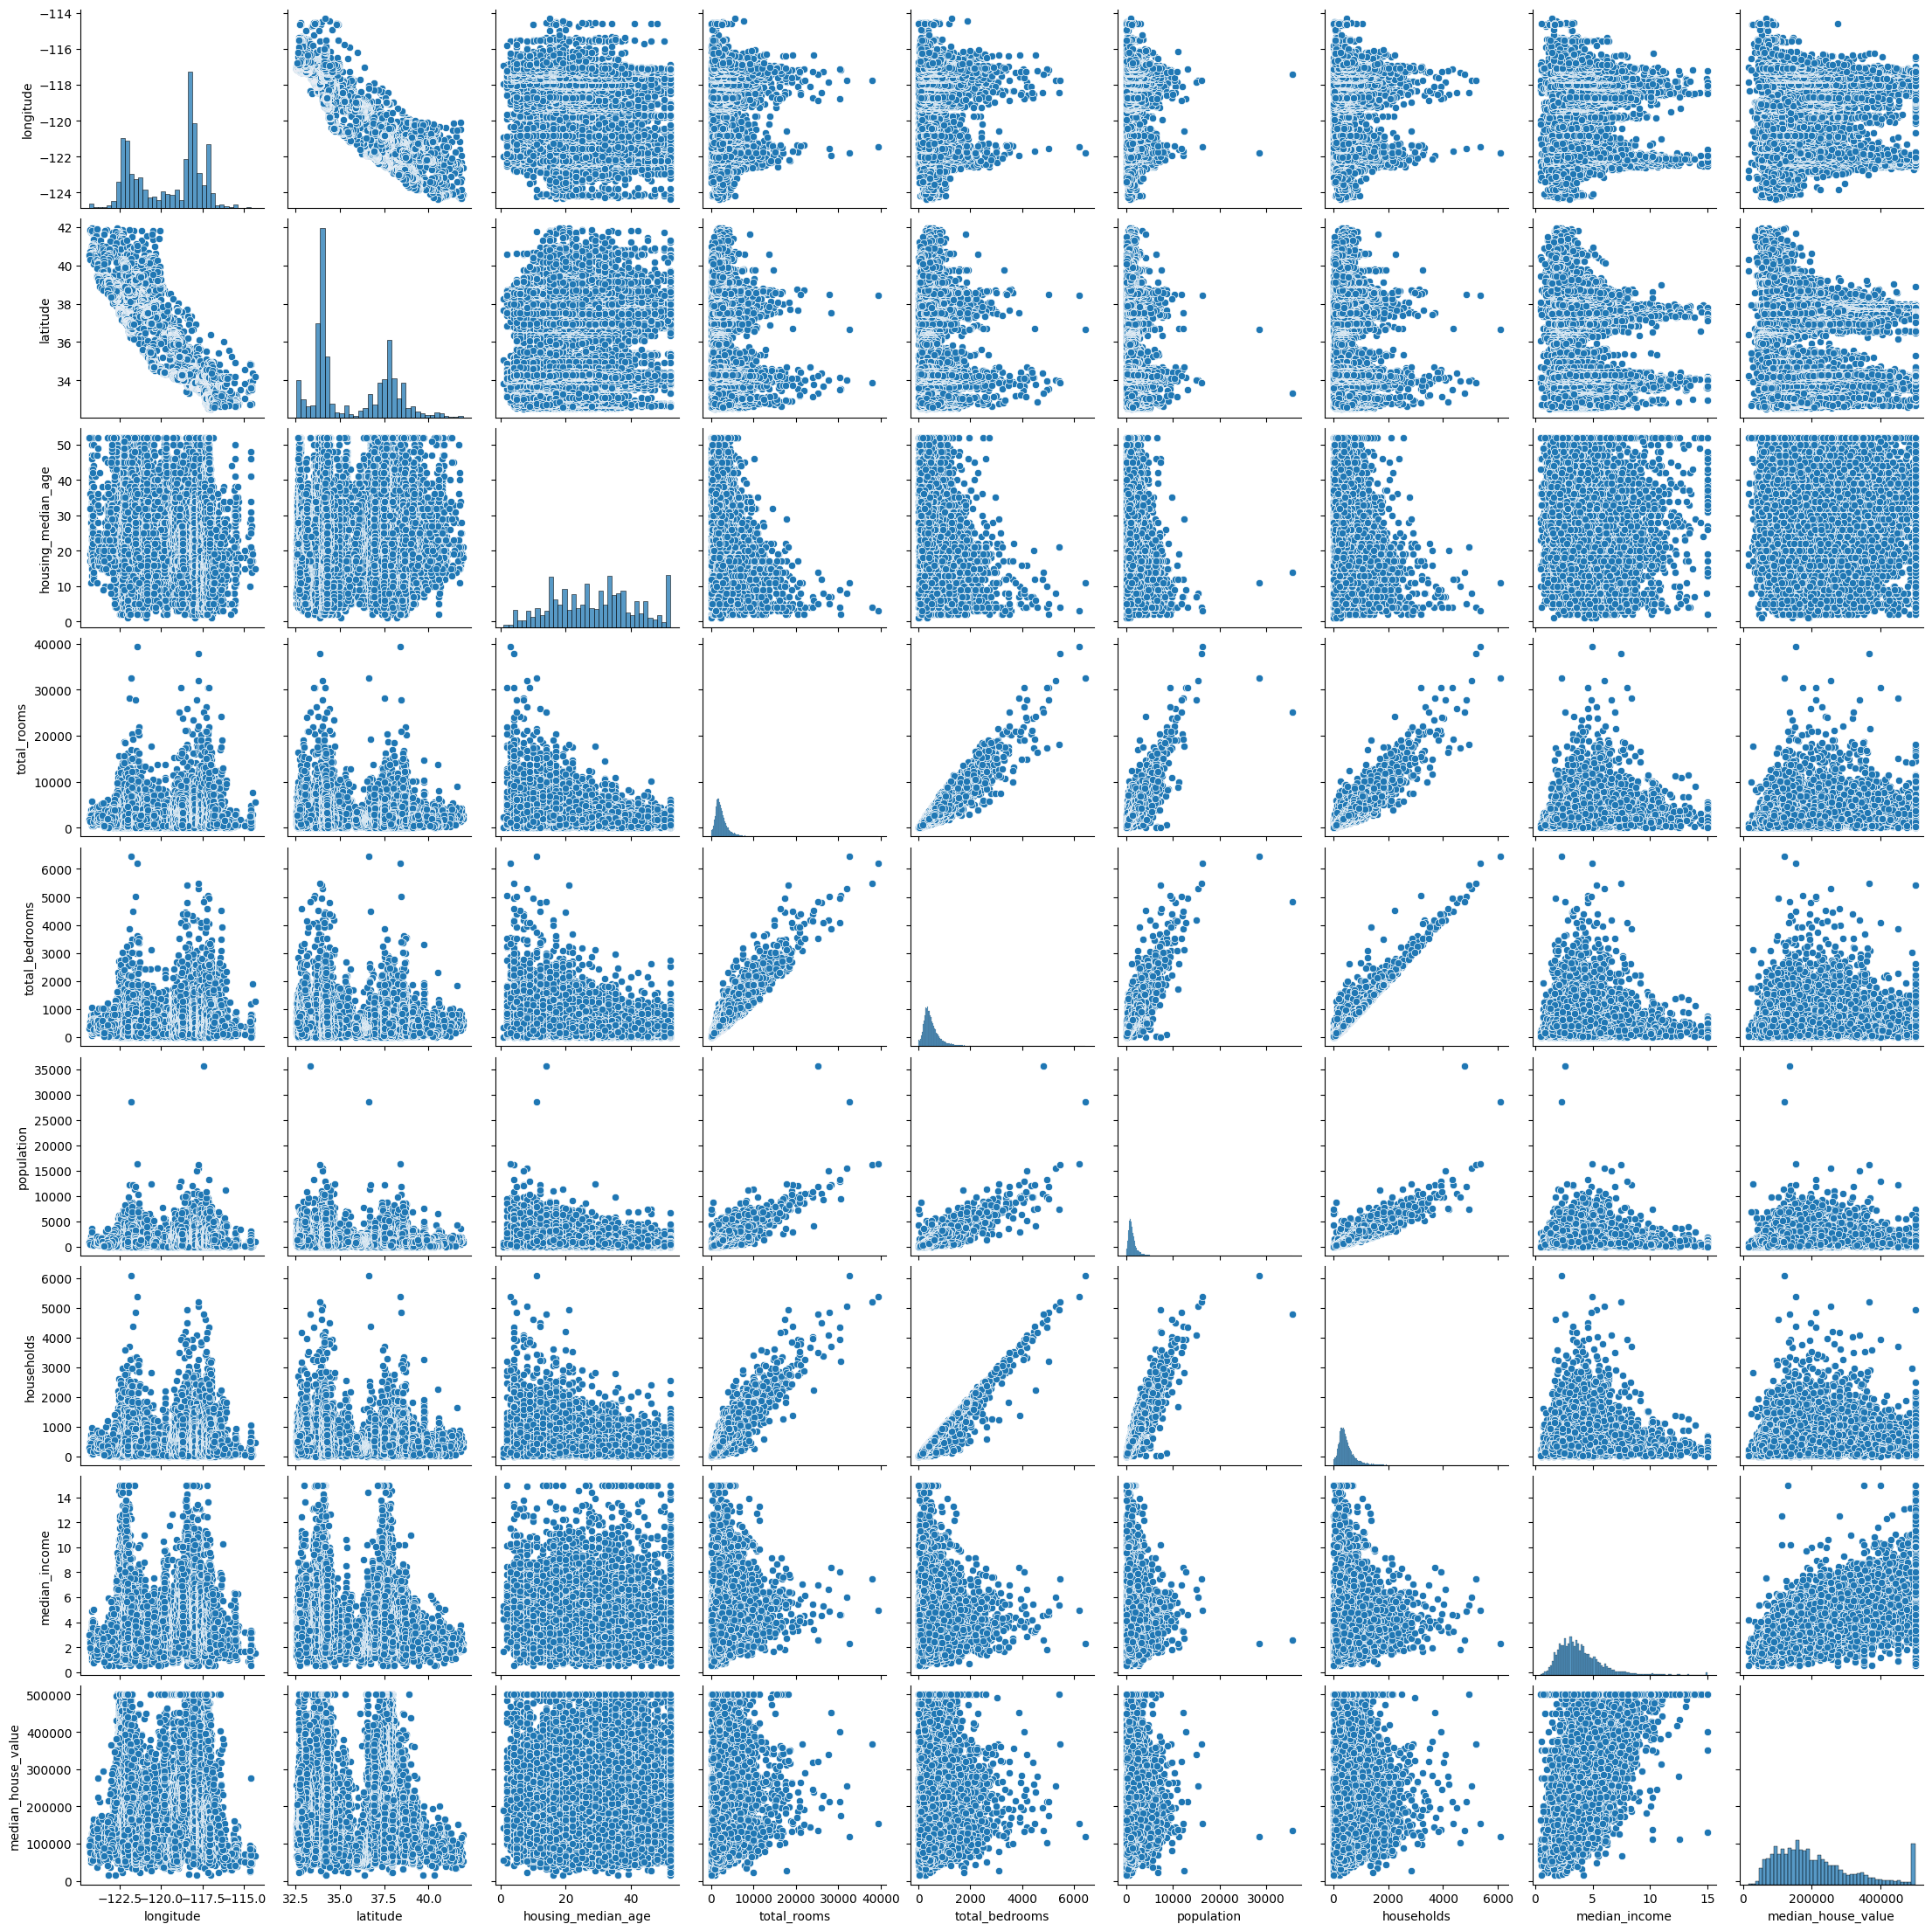

In [12]:
sns.pairplot(cali_house)

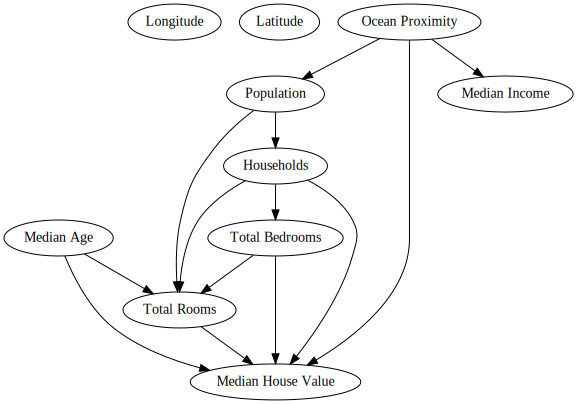

In [13]:
b_dag = gv.Digraph(name="California Housing")

b_dag.node('G','Longitude')
b_dag.node('T','Latitude')
b_dag.node('A','Median Age')
b_dag.node('R','Total Rooms')
b_dag.node('B','Total Bedrooms')
b_dag.node('P','Population')
b_dag.node('H','Households')
b_dag.node('I','Median Income')
b_dag.node('V','Median House Value')
b_dag.node('O','Ocean Proximity')

b_dag.edges(['AV','RV','BV','PH','HV','OV','AR','OI','HB','PR','BR','OP','HR'])

b_dag

My causal diagram has lots of relationships, with median house value having the most predictors, including number of rooms, age, households, and ocean proximity. Because of this, my original intention was to predict the median house value; however, after continually getting an error for the starting point failing (likely due to such a large data set), I switched to predicting the total number of rooms from the surrounding households, bedrooms, and population. These variables also have the strongest linear relationships from the pair plot above.



---



# **MODELS**

In [38]:
cali_house = pd.read_csv('https://raw.githubusercontent.com/eemaansheikh/Data_Science_2025/refs/heads/main/housing%5B1%5D.csv')
cali_house_cleaned = cali_house.dropna(subset=['total_bedrooms', 'population', 'households', 'total_rooms'])

#we put the priors that aren't normal or half normal with mean 0 and sigma 1
#in a dict
priors ={
    "population" : bmb.Prior("Normal", mu=0,sigma=1),
    "households" : bmb.Prior("Normal", mu=0,sigma=1),
    "total_bedrooms" : bmb.Prior("Normal", mu=0,sigma=1),
    "alpha" : bmb.Prior("HalfNormal",sigma=10)
}

#This creates a skeleton of the model; it hasn't run MCMC or created a posterior yet
model_cali_house_bmb = bmb.Model("total_rooms ~ population + households + total_bedrooms", cali_house_cleaned, family = "negativebinomial", priors=priors)

In [ ]:
idata_cali_house_bmb = model_cali_house_bmb.fit(init='adapt_diag')

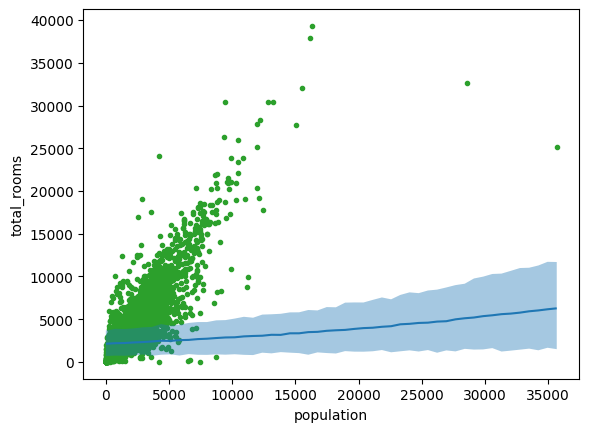

In [17]:
bmb.interpret.plot_predictions(model_cali_house_bmb, idata_cali_house_bmb, "population", pps=True)
plt.plot(cali_house_cleaned.population, cali_house_cleaned.total_rooms, "C2.", zorder=-3)

Model for Population was not well correlated within the range. This model proved that population was not a good predictor for the number of rooms in a house.

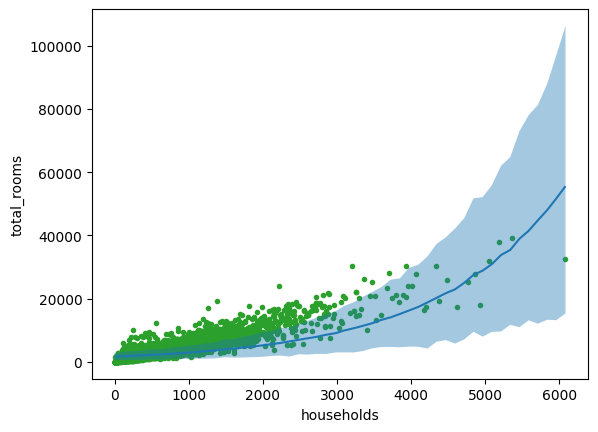

In [18]:
bmb.interpret.plot_predictions(model_cali_house_bmb, idata_cali_house_bmb, "households", pps=True)
plt.plot(cali_house_cleaned.households, cali_house_cleaned.total_rooms, "C2.", zorder=-3)

Also not the best model possible, but the scatter plot follows the general curve and is more concentrated toward the values closer to 0. This is because the total number of rooms is not likely to exceed a certain amount even with an increase of households.

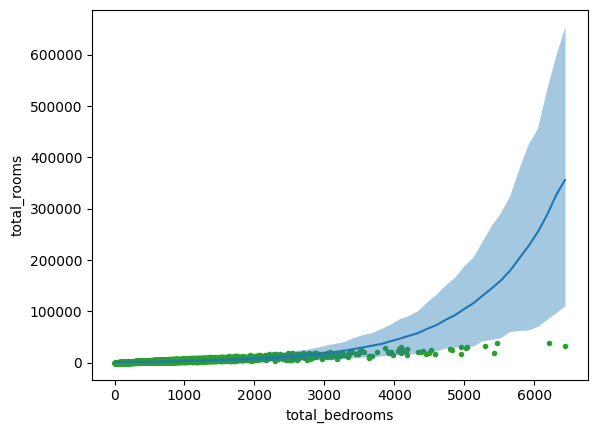

In [19]:
bmb.interpret.plot_predictions(model_cali_house_bmb, idata_cali_house_bmb, "total_bedrooms", pps=True)
plt.plot(cali_house_cleaned.total_bedrooms, cali_house_cleaned.total_rooms, "C2.", zorder=-3)

Similarly, though this is not the strongest model possible, the scatter plot is within the blue range and mostly follows the curve. Once again, even with an increase in bedrooms, the total rooms in a house can't exceed a certain point, which is why the points stays toward the beginning/bottom of the curve.

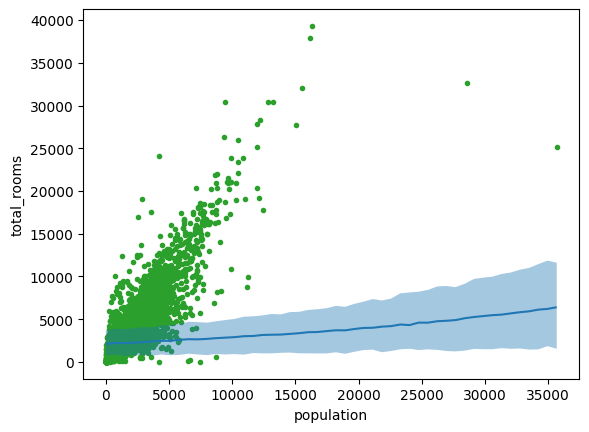

In [43]:
bmb.interpret.plot_predictions(model_cali_house_bmb, idata_cali_house_bmb, "population", pps=True)
plt.plot(cali_house_cleaned.population, cali_house_cleaned.total_rooms, "C2.", zorder=-3)

The model which uses all three as variables is also inaccurate and follows a similar trend to that of the first model, leading me to believe that the problematic predictor might be population.



---



In [ ]:
import bambi as bmb
#define a new model with interaction; bb_interq stands for basketball interaction quantitative
model_cali_house_interaction = bmb.Model("`total_rooms` ~ `total_bedrooms` + `households` + `total_bedrooms`:`households`", data=cali_house_cleaned)
#create the model's inference data
idata_cali_house_interaction = model_cali_house_interaction.fit(idata_kwargs={'log_likelihood': True})

(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='total_bedrooms', ylabel='total_rooms'>],
       dtype=object))

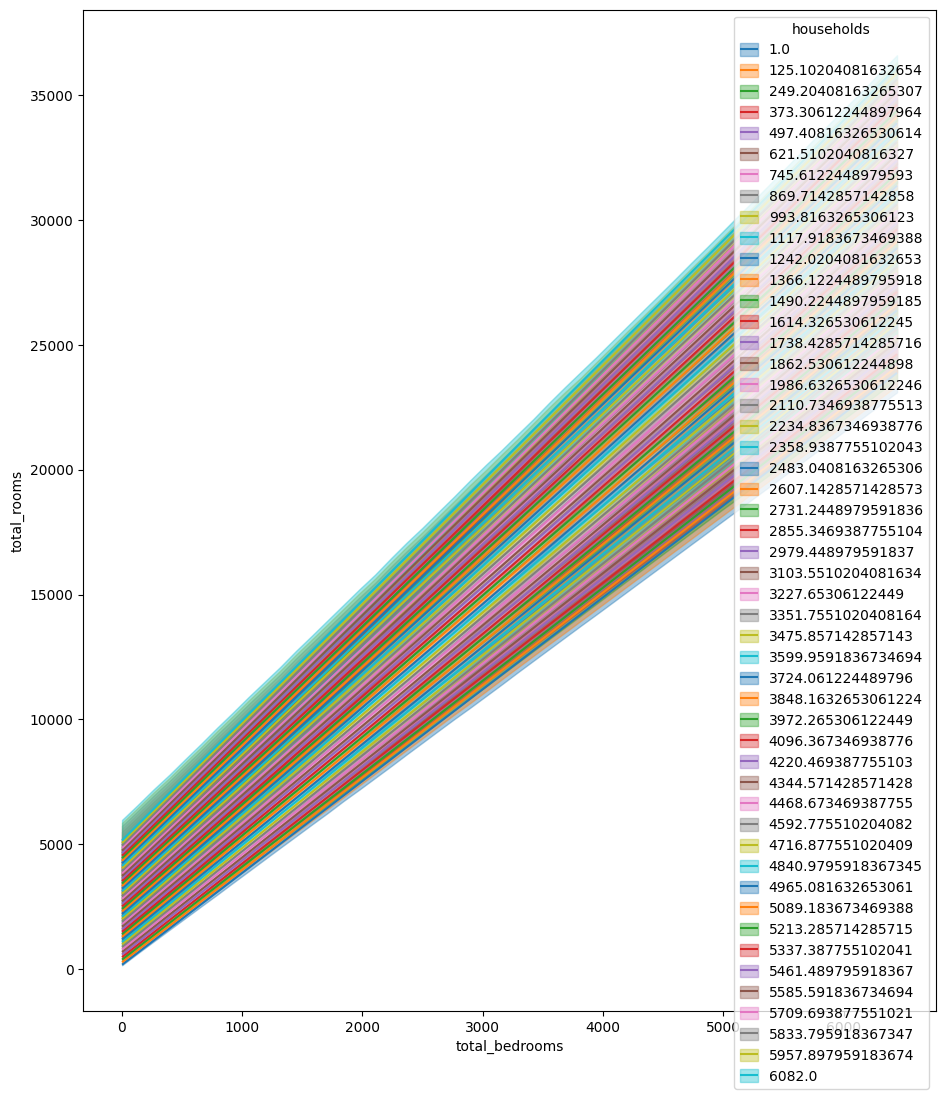

In [25]:
bmb.interpret.plot_predictions(model_cali_house_interaction,
                               idata_cali_house_interaction,
                               ["total_bedrooms","households"],
                               fig_kwargs={"figsize":(11, 13)})

IN order to test the added inaccuracy of population as a predictor, I made the model above with just total bedrooms and households, two of the better models. The linear model above shows how both, an increase in total bedrooms and an increase in surrounding households, increase the number of total rooms. This indicates an overall positive linear relationship.

In [26]:
cali_house = pd.read_csv('https://raw.githubusercontent.com/eemaansheikh/Data_Science_2025/refs/heads/main/housing%5B1%5D.csv')
# Clean the data by dropping rows with missing values in 'total_bedrooms' and all predictor variables
cali_house_cleaned = cali_house.dropna(subset=['total_bedrooms', 'population', 'households', 'total_rooms'])

In [ ]:
#define the model
model_cali_house = bmb.Model("`total_rooms` ~ `total_bedrooms` + households", data=cali_house_cleaned)
#fit the model
idata_cali_house = model_cali_house.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_cali_house_4 = bmb.Model("`total_rooms` ~ `population` + `total_bedrooms`+ households", data=cali_house_cleaned)
#fit the model
idata_cali_house_4 = model_cali_house_4.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_cali_house_5 = bmb.Model("`total_rooms` ~ `population`", data=cali_house_cleaned)
#fit the model
idata_cali_house_5 = model_cali_house_5.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_cali_house_6 = bmb.Model("`total_rooms` ~`total_bedrooms`", data=cali_house_cleaned)
#fit the model
idata_cali_house_6 = model_cali_house_6.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
#define the model
model_cali_house_7 = bmb.Model("`total_rooms` ~ households", data=cali_house_cleaned)
#fit the model
idata_cali_house_7 = model_cali_house_7.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
cmp_df = az.compare({
    'population + households': idata_cali_house,
    'population + total_rooms + households': idata_cali_house_4,
    'population': idata_cali_house_5,
    'total_rooms': idata_cali_house_6,
    'households':idata_cali_house_7
})

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

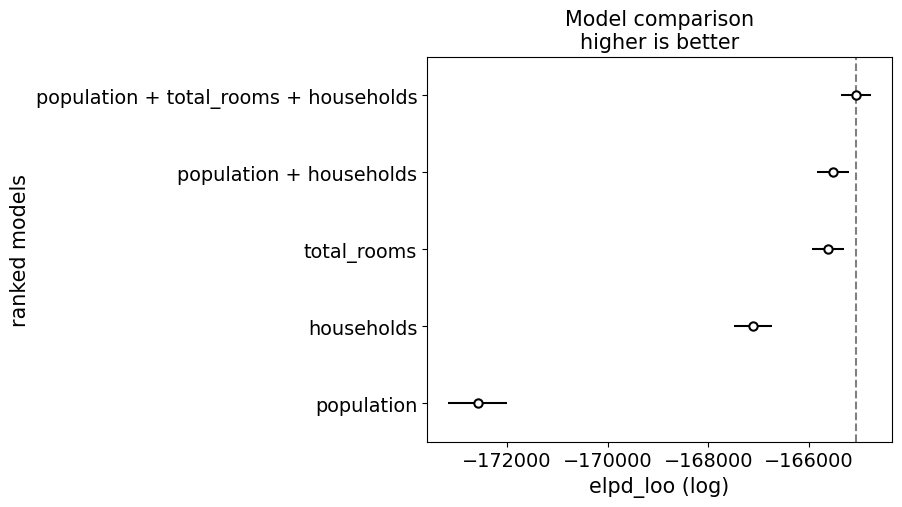

In [35]:
az.plot_compare(cmp_df)

I was surprised to see that the model with the highest accuracy, contrary to the models above, was that of all three predictors combined (population + total_rooms + households). The next lowest elpd_loo score was the combination of population + households, and surprisingly doesn't include total rooms. When looking on an individual basis, however, total rooms has the highest accuracy, and population has the lowest, which seems most corresponsive with the matplot models above.

# **CONCLUSION**

Population, total bedrooms, and households has the most accuracy to predict the total number of rooms in a California House.